# Problema

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da
base.

Para isso utilize a base de dados contida no site da investing e selecione o período "diário", com o intervalo
de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

*   O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
*   Justificar a técnica utilizada;
*   Atingir uma acuracidade adequada (acima de 70%).

In [ ]:
!pip install pycaret[analysis,models]

In [ ]:
!pip install pycaret

In [28]:
%%capture
!pip install kaleido
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

import yfinance as yf

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"

# Importando biblioteca de regressão do Pycaret
from pycaret.regression import *

In [30]:
df_bovespa = pd.read_csv("https://raw.githubusercontent.com/karinaguerra/postech-data-analytics-tech-challenge/main/fase_2/dados/dados_ibovespa.csv")

In [31]:
df_bovespa.head(3)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,09.02.2024,127.788,128.216,128.896,127.734,"5,48M","-0,33%"
1,08.02.2024,128.217,129.950,130.126,127.912,"13,63M","-1,33%"
2,07.02.2024,129.950,130.412,130.552,129.426,"15,43M","-0,36%"


In [32]:
df_bovespa.shape

(2478, 7)

In [33]:
df_bovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      2478 non-null   object 
 1   Último    2478 non-null   float64
 2   Abertura  2478 non-null   float64
 3   Máxima    2478 non-null   float64
 4   Mínima    2478 non-null   float64
 5   Vol.      2477 non-null   object 
 6   Var%      2478 non-null   object 
dtypes: float64(4), object(3)
memory usage: 135.6+ KB


In [34]:
df_bovespa.rename(columns={
    'Data': 'data',
    'Último': 'ultimo',
    'Abertura': 'abertura',
    'Máxima': 'maxima',
    'Mínima': 'minima'
}, inplace=True)

In [35]:
df_bovespa['data'] = pd.to_datetime(df_bovespa['data'], format='%d.%m.%Y')

In [36]:
df_bovespa.sort_values(by=['data'], ascending=True, inplace=True)

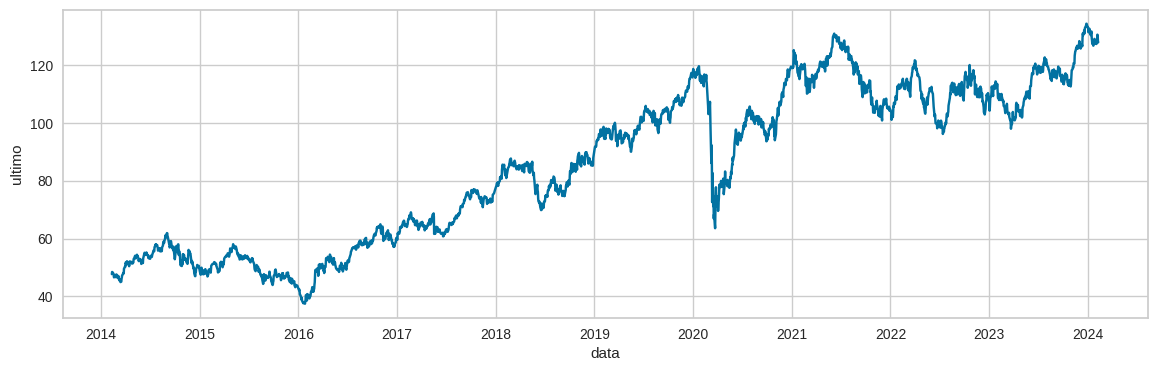

In [37]:
plt.figure(figsize=(14, 4))

sns.lineplot(data=df_bovespa, x='data', y='ultimo');

In [38]:
# Tranformar a coluna Data em index
df_bovespa.set_index('data', inplace=True)

# Drop e excluir as colunas Vol. e Var%
df_bovespa.drop(columns=['Vol.', 'Var%'], inplace=True)

# Adicionando Médias Móveis para acrescentar mais features ao modelo
df_bovespa['SMA7'] = df_bovespa.ultimo.rolling(window=7).mean().round(2)
df_bovespa['SMA30'] = df_bovespa.ultimo.rolling(window=30).mean().round(2)

In [39]:
df_bovespa.head()

,ultimo,abertura,maxima,minima,SMA7,SMA30
data,,,,,,
2014-02-10,47.711,48.070,48.136,47.465,NaN,NaN
2014-02-11,48.463,47.715,48.604,47.589,NaN,NaN
2014-02-12,48.217,48.467,48.669,48.044,NaN,NaN
2014-02-13,47.813,48.211,48.211,47.129,NaN,NaN
2014-02-14,48.201,47.816,48.314,47.756,NaN,NaN


In [40]:
bovespa_teste = df_bovespa.tail(365)
bovespa_teste.head()

,ultimo,abertura,maxima,minima,SMA7,SMA30
data,,,,,,
2022-08-24,112.898,112.856,113.888,112.632,112.68,105.49
2022-08-25,113.532,112.898,114.156,112.768,112.69,106.07
2022-08-26,112.299,113.533,114.091,111.978,112.49,106.59
2022-08-29,112.323,112.296,113.222,111.689,112.27,107.11
2022-08-30,110.431,112.323,112.869,110.103,112.12,107.51


In [41]:
# Removendo os últimos 253 dias do dataframe original
df_bovespa.drop(df_bovespa.tail(365).index, inplace=True)
# Removendo dados nulos
df_bovespa.dropna(inplace=True)

In [42]:
# Removendo índices de ambos os dataframes
#df_bovespa.reset_index(drop=True, inplace=True)
#bovespa_teste.reset_index(drop=True, inplace=True)

In [43]:
df_bovespa.shape

(2084, 6)

In [44]:
bovespa_teste.shape

(365, 6)

In [45]:
df_bovespa

,ultimo,abertura,maxima,minima,SMA7,SMA30
data,,,,,,
2014-03-25,48.180,47.993,48.441,47.950,46.95,46.93
2014-03-26,47.966,48.182,48.725,47.963,47.36,46.94
2014-03-27,49.647,47.965,49.647,47.962,47.86,46.98
2014-03-28,49.768,49.653,50.181,49.606,48.32,47.03
2014-03-31,50.415,49.770,50.418,49.770,48.76,47.12
...,...,...,...,...,...,...
2022-08-17,113.708,113.508,114.146,112.483,111.66,103.28
2022-08-18,113.813,113.708,114.375,113.304,112.40,103.72
2022-08-19,111.496,113.807,113.807,111.146,112.58,104.09


In [46]:
 # Visualizando correlações entre as variáveis
bovespa_teste.corr()

,ultimo,abertura,maxima,minima,SMA7,SMA30
ultimo,1.000000,0.986108,0.995637,0.995158,0.975217,0.889901
abertura,0.986108,1.000000,0.993880,0.994226,0.984191,0.900266
maxima,0.995637,0.993880,1.000000,0.995714,0.981133,0.898179
minima,0.995158,0.994226,0.995714,1.000000,0.980352,0.893886
SMA7,0.975217,0.984191,0.981133,0.980352,1.000000,0.930642
SMA30,0.889901,0.900266,0.898179,0.893886,0.930642,1.000000


In [47]:
# Configurando o Pycaret para receber nossos dados para modelagem
setup(data = df_bovespa, target = 'ultimo', session_id=123)

,Description,Value
0,Session id,123
1,Target,ultimo
2,Target type,Regression
3,Original data shape,"(2084, 6)"
4,Transformed data shape,"(2084, 6)"
5,Transformed train set shape,"(1458, 6)"
6,Transformed test set shape,"(626, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [48]:
melhormodelo = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.3445,0.2195,0.4659,0.9997,0.0057,0.0044,1.1080
br,Bayesian Ridge,0.3446,0.2195,0.4660,0.9997,0.0057,0.0044,0.0380
huber,Huber Regressor,0.3398,0.2216,0.4676,0.9997,0.0057,0.0043,0.1130
ridge,Ridge Regression,0.3447,0.2195,0.4660,0.9997,0.0057,0.0044,0.0460
lar,Least Angle Regression,0.3445,0.2195,0.4659,0.9997,0.0057,0.0044,0.0410
en,Elastic Net,0.4640,0.4048,0.6311,0.9994,0.0078,0.0059,0.0510
llar,Lasso Least Angle Regression,0.4638,0.3901,0.6211,0.9994,0.0077,0.0059,0.0550
lasso,Lasso Regression,0.4701,0.4367,0.6521,0.9993,0.0080,0.0060,0.0390
et,Extra Trees Regressor,0.4780,0.5207,0.7067,0.9992,0.0088,0.0061,0.2730
rf,Random Forest Regressor,0.4945,0.5368,0.7169,0.9991,0.0090,0.0064,0.7970


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [49]:
melhormodelo

LinearRegression(n_jobs=-1)

In [50]:
# Testando os modelos 10 vezes e vendo as médias das métricas de acurácia
lr = create_model('lr', fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3457,0.1867,0.4321,0.9997,0.0056,0.0045
1,0.3900,0.3055,0.5527,0.9995,0.0063,0.0048
2,0.3169,0.1926,0.4388,0.9997,0.0058,0.0042
3,0.3248,0.1823,0.4269,0.9997,0.0051,0.0040
4,0.4012,0.3021,0.5496,0.9995,0.0065,0.0050
5,0.3507,0.2036,0.4512,0.9997,0.0057,0.0045
6,0.3596,0.2585,0.5084,0.9995,0.0065,0.0045
7,0.3003,0.1656,0.4069,0.9997,0.0050,0.0039
8,0.3319,0.2018,0.4492,0.9997,0.0054,0.0043


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [51]:
br = create_model('br', fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3459,0.1868,0.4322,0.9997,0.0056,0.0045
1,0.3899,0.3052,0.5525,0.9995,0.0063,0.0048
2,0.3171,0.1929,0.4392,0.9997,0.0058,0.0042
3,0.3250,0.1823,0.4270,0.9997,0.0051,0.0040
4,0.4012,0.3020,0.5495,0.9995,0.0065,0.0050
5,0.3508,0.2037,0.4513,0.9997,0.0057,0.0045
6,0.3598,0.2585,0.5084,0.9995,0.0065,0.0045
7,0.3004,0.1654,0.4067,0.9997,0.0050,0.0039
8,0.3320,0.2018,0.4492,0.9997,0.0054,0.0043


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [52]:
huber = create_model('huber', fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3308,0.1780,0.4218,0.9997,0.0055,0.0043
1,0.4004,0.3242,0.5694,0.9995,0.0065,0.0049
2,0.3003,0.1741,0.4173,0.9997,0.0055,0.0040
3,0.3213,0.1870,0.4324,0.9997,0.0052,0.0040
4,0.3981,0.3105,0.5572,0.9995,0.0066,0.0049
5,0.3427,0.2018,0.4492,0.9997,0.0057,0.0044
6,0.3558,0.2662,0.5159,0.9995,0.0066,0.0045
7,0.2983,0.1724,0.4152,0.9997,0.0050,0.0038
8,0.3307,0.2043,0.4519,0.9997,0.0054,0.0042


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

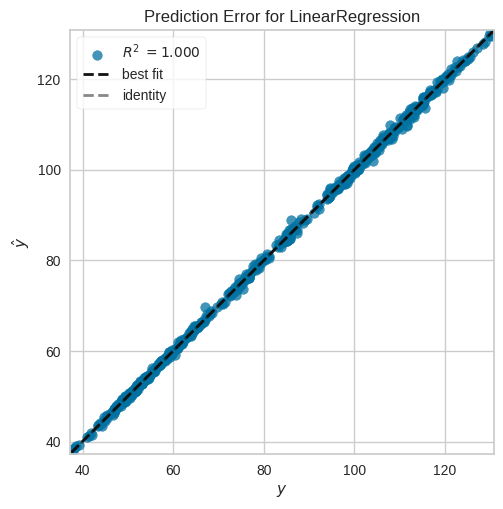

In [53]:
# Plotando gráfico de erro
plot_model(lr, plot='error')

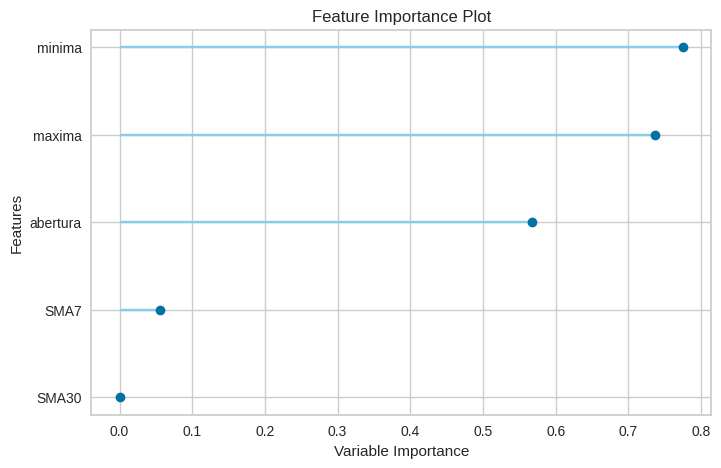

In [54]:
plot_model(lr, plot='feature') # feature melhor utilizada no modelo

In [55]:
# Testando com dados de treinamento para ver as métricas de acurácia
predict_model(lr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.3838,0.2770,0.5263,0.9996,0.0064,0.0048


,abertura,maxima,minima,SMA7,SMA30,ultimo,prediction_label
data,,,,,,,
2019-11-26,108.424004,108.424004,106.414001,107.190002,107.110001,107.058998,106.865662
2019-11-07,108.360001,109.671997,108.360001,108.470001,105.360001,109.581001,109.401443
2015-07-07,52.148998,52.388000,51.130001,52.709999,53.349998,52.344002,51.599472
2022-05-30,111.944000,112.690002,110.654999,110.690002,108.760002,111.031998,111.495132
2019-01-23,95.115997,96.575996,95.115997,95.370003,90.400002,96.557999,96.265327
...,...,...,...,...,...,...,...
2014-12-18,48.714001,49.564999,48.296001,48.380001,51.820000,48.495998,49.030357
2014-07-01,53.169998,53.698002,52.887001,53.560001,53.240002,53.171001,53.395016
2018-02-01,84.913002,86.028000,84.833000,84.209999,79.349998,85.495003,85.685936


In [56]:
# Finalizando o modelo e fazendo a previsão dos últimos 253 dias de pregão
bovespa_modelo_final = finalize_model(lr)

In [57]:
# Prevendo os ultimos 253 dias
prev = predict_model(bovespa_modelo_final, data = bovespa_teste)
prev[['ultimo','prediction_label']].round(2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.4043,0.2648,0.5146,0.9959,0.0045,0.0036


,ultimo,prediction_label
data,,
2022-08-24,112.900002,113.580002
2022-08-25,113.529999,113.849998
2022-08-26,112.300003,112.809998
2022-08-29,112.320000,112.629997
2022-08-30,110.430000,111.110001
...,...,...
2024-02-05,127.589996,127.209999
2024-02-06,130.419998,129.750000
2024-02-07,129.949997,129.699997


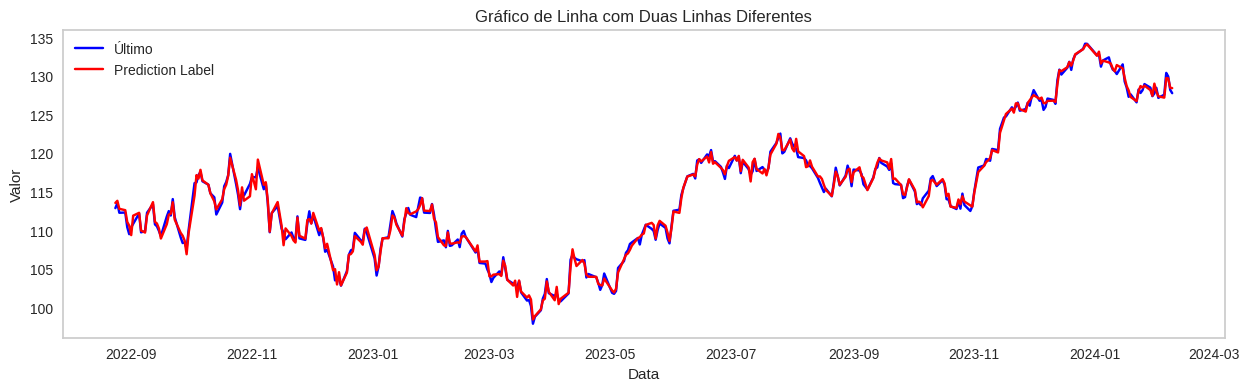

In [72]:
import matplotlib.pyplot as plt

df = pd.DataFrame(prev)

plt.figure(figsize=(15,4))
# Plotar o gráfico de linha com duas linhas diferentes
plt.plot(df['ultimo'], label='Último', color='blue')  # Linha azul
plt.plot(df['prediction_label'], label='Prediction Label', color='red')  # Linha vermelha


plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Gráfico de Linha com Duas Linhas Diferentes')
plt.grid(False)
plt.legend()
plt.show()